In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel


import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240119-3.csv')
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')

# L2 PCA 

In [3]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Remove specified columns
columns_to_remove = ['Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_remove)

# Merge with venue information
df = pd.merge(df, df_venue[['EVSE ID', 'Charging Venue', 'Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude (y)', 'Longitude (x)']], on='EVSE ID', how='left')

# ZIP code distance  Zip/Postal Code    and   Driver Zip/Postal Code

# Initialize the Search Engine
search = SearchEngine()

# Initialize pandarallel
pandarallel.initialize()


zip_dict = {}

def get_lat_long(zip_code):
    if pd.isna(zip_code):
        return (None, None)
    if zip_code not in zip_dict:
        result = search.by_zipcode(zip_code)
        if result:
            zip_dict[zip_code] = (result.lat, result.lng)
        else:
            zip_dict[zip_code] = (None, None)  # Default value
    return zip_dict[zip_code]



def calculate_distance(row):
    try:
        # Get the lat, long for both zip codes
        loc1 = get_lat_long(row['Zip/Postal Code'])
        loc2 = get_lat_long(row['Driver Zip/Postal Code'])

        # If either location is None, return None
        if None in loc1 or None in loc2:
            return None


        return geodesic(loc1, loc2).miles
    except Exception as e:
        print(f"Error: {e}")
        return None


# Apply the function to your DataFrame
df['zip_dis'] = df.parallel_apply(calculate_distance, axis=1)
df['zip_dis'].fillna(df['zip_dis'].median(), inplace=True)


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_86564\2357781281.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['zip_dis'].fillna(df['zip_dis'].median(), inplace=True)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_86564\2357781281.py:54: FutureWarning: Downcasting object dtype

In [4]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])
#df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
#df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]




# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)

# Add VENUE features


#df['ven_hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)
df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Medical') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_muni'] = (df['Charging Venue'] == 'Citty Hall').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Retail').astype(int)
#df['ven_transit'] = (df['Charging Venue'] == 'Transit').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()


#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']

#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------

####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
df_TN=df[df['State/Province']=='Tennessee']

# PCA

In [5]:
#Station utilization: The average energy delivered by a station during a time period divided by the number of ports a

df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

# 2023
#df_tennessee_2023 = df[(df['State/Province'] == 'Tennessee') & (df['Start_Time_EST'].dt.year == 2023)]
#df_tennessee_2023 = df[df['Start_Time_EST'].dt.year == 2023]


unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID
daily_events = df.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   average daily basis in kilowatt-hours per port per day
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')

# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)



merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

merged_df_GIS = df_GIS[['EVSE ID', 'Business_Dis', 'Business_Name', 'Business_Label', 'Grocery_Dis', 'Grocer_ Name', 'County_population_2021',
                         'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name', 'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 
                         'Hotel_Label', 'Parks_Dis', 'Parks_Name', 'Park_Label',
                         'Comprehensive_Dis', 'Comprehencive_Name', 'Comp_Label', 'Weight']].drop_duplicates()

utilization_station_data = pd.merge(utilization_station_data, merged_df_GIS, on='EVSE ID', how='left')

# Add EV for TN 
#tn_ev_county= df_tn_reg.groupby(['County'])['Vehicle Count'].sum().reset_index()
#utilization_station_data = pd.merge(utilization_station_data, tn_ev_county, on='County', how='left')
#utilization_station_data['percentage of poulation']=(utilization_station_data['Vehicle Count']*100)/utilization_station_data['County_population_2021']
#utilization_station_data.dropna(subset=['percentage of poulation'], inplace=True)



# Normalized Event count 
merged_df_normalized =  df[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports', 'Utilization Rate']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')



# Station utilization  (kWh/port/day)
# station utilization as the average energy delivered by a station during a time period divided by the number of ports.

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']


#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Medical' )).astype(int)
utilization_station_data['ven_muni'] = (utilization_station_data['Charging Venue'] == 'Citty Hall').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Retail').astype(int)
utilization_station_data['ven_transit'] = (utilization_station_data['Charging Venue'] == 'Transit').astype(int)

# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)

# demographic data 
search = SearchEngine()

def get_demographics(zip_code):
    result = search.by_zipcode(zip_code)
    return result.population, result.population_density, result.median_home_value, result.median_household_income

utilization_station_data['population'], utilization_station_data['population_density'], utilization_station_data['median_home_value'],  utilization_station_data['median_household_income'] =  zip(*utilization_station_data['Zip/Postal Code'].apply(get_demographics))
columns_to_convert_to_float = ['population', 'population_density', 'median_home_value']
utilization_station_data[columns_to_convert_to_float] = utilization_station_data[columns_to_convert_to_float].astype(float)

columns_with_inf = ['Normalized Event Count', 'Utilization Rate']
utilization_station_data[columns_with_inf] = utilization_station_data[columns_with_inf].replace([np.inf, -np.inf], np.nan)
utilization_station_data[columns_with_inf] = utilization_station_data[columns_with_inf].fillna(utilization_station_data[columns_with_inf].mean())


# DF for L2 and DC 
df_station_daily_L2 = utilization_station_data[utilization_station_data['Port Type'].str.fullmatch('Level 2')]
#df_station_daily_DC = utilization_station_data[utilization_station_data['Port Type'].str.fullmatch('DC Fast')]



independent_vars = ['Fee', 'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 
                    'Business_Label', 'HWY_Label', 'Hotel_Label', 'Weight', 
                    'Normalized Event Count', 'ven_leisure', 'ven_med_ed', 
                    'ven_muni', 'ven_office', 'ven_parking', 'ven_retail', 
                    'cost_free', 'cost_paid', 'Utilization Rate',
                    'median_household_income','population_density']

X = df_station_daily_L2[independent_vars]
Y = df_station_daily_L2['Util_station (kWh/port/day)']

# Check for infinity and NaN
is_infinite = np.isinf(X).any()
print("Infinite values in independent variables:")
print(is_infinite)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep components explaining at least 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the number of components selected
n_components = pca.n_components_
print("Number of components selected by PCA:", n_components)

# Now, you can use X_pca instead of X in your further analysis

# Split the PCA transformed data
X_train_pca, X_temp_pca, Y_train_pca, Y_temp_pca = train_test_split(X_pca, Y, test_size=0.3, random_state=42)
X_val_pca, X_test_pca, Y_val_pca, Y_test_pca = train_test_split(X_temp_pca, Y_temp_pca, test_size=0.5, random_state=42)

print("Training set (after PCA):", X_train_pca.shape, Y_train_pca.shape)
print("Validation set (after PCA):", X_val_pca.shape, Y_val_pca.shape)
print("Testing set (after PCA):", X_test_pca.shape, Y_test_pca.shape)

# Model training after PCA
model_pca = LinearRegression()
model_pca.fit(X_train_pca, Y_train_pca)

# Evaluation after PCA
train_score_pca = model_pca.score(X_train_pca, Y_train_pca)
val_score_pca = model_pca.score(X_val_pca, Y_val_pca)
test_score_pca = model_pca.score(X_test_pca, Y_test_pca)

print("Training R^2 score (after PCA):", train_score_pca)
print("Validation R^2 score (after PCA):", val_score_pca)
print("Testing R^2 score (after PCA):", test_score_pca)

# Additional: if you still want to check the summary of the model after PCA
model_pca_summary = sm.OLS(Y_train_pca, sm.add_constant(X_train_pca)).fit()
print(model_pca_summary.summary())


Infinite values in independent variables:
Fee                        False
Day_of_Week                False
Is_Weekday                 False
Is_Weekend                 False
Business_Label             False
HWY_Label                  False
Hotel_Label                False
Weight                     False
Normalized Event Count     False
ven_leisure                False
ven_med_ed                 False
ven_muni                   False
ven_office                 False
ven_parking                False
ven_retail                 False
cost_free                  False
cost_paid                  False
Utilization Rate           False
median_household_income    False
population_density         False
dtype: bool
Number of samples in X: 13707
Number of samples in Y: 13707
Number of components selected by PCA: 12
Training set (after PCA): (9594, 12) (9594,)
Validation set (after PCA): (2056, 12) (2056,)
Testing set (after PCA): (2057, 12) (2057,)
Training R^2 score (after PCA): 0.492850288240891

In [6]:
print(model_pca_summary.summary())

                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.493
Model:                                     OLS   Adj. R-squared:                  0.492
Method:                          Least Squares   F-statistic:                     775.9
Date:                         Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                                 23:28:52   Log-Likelihood:                -33898.
No. Observations:                         9594   AIC:                         6.782e+04
Df Residuals:                             9581   BIC:                         6.791e+04
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:


# Calculate VIF for PCA transformed features
vif_pca = pd.DataFrame()
vif_pca["PC"] = [f"PC_{i+1}" for i in range(n_components)]
vif_pca["VIF"] = [variance_inflation_factor(X_pca, i) for i in range(n_components)]
print("Variance Inflation Factor (VIF) for PCA transformed features:")
print(vif_pca)


Variance Inflation Factor (VIF) for PCA transformed features:
       PC  VIF
0    PC_1  1.0
1    PC_2  1.0
2    PC_3  1.0
3    PC_4  1.0
4    PC_5  1.0
5    PC_6  1.0
6    PC_7  1.0
7    PC_8  1.0
8    PC_9  1.0
9   PC_10  1.0
10  PC_11  1.0
11  PC_12  1.0


In [25]:


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_pca, Y_train_pca)

Y_val_pred = rf_model.predict(X_val_pca)

val_score_rf = r2_score(Y_val_pca, Y_val_pred)
print("Validation R^2 score (Random Forest):", val_score_rf)


Y_test_pred = rf_model.predict(X_test_pca)


test_score_rf = r2_score(Y_test_pca, Y_test_pred)
print("Test R^2 score (Random Forest):", test_score_rf)


Validation R^2 score (Random Forest): 0.6398110217611366
Test R^2 score (Random Forest): 0.6626184066634146


# RF Hyperparameter PCA

c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
257 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\skl

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Iteration 1: 'max_features' is set to 'auto', skipping...
Iteration 2: 'max_features' is set to 'auto', skipping...
Iteration 3: 'max_features' is set to 'auto', skipping...
Iteration 4: 'max_features' is set to 'auto', skipping...
Iteration 5: 'max_features' is set to 'auto', skipping...
Iteration 6: 'max_features' is set to 'auto', skipping...
Iteration 7: 'max_features' is set to 'auto', skipping...
Iteration 8: 'max_features' is set to 'auto', skipping...
Iteration 9: 'max_features' is set to 'auto', skipping...
Iteration 10: 'max_features' is set to 'auto', skipping...
Iteration 11: 'max_features' is set to 'auto', skipping...
Iteration 12: 'max_features' is set to 'auto', skipping...
Iteration 13: 'max_features' is set to 'auto', skipping...
Iteration 14: 'max_features' is set to 'auto', skipping...
Iteration 15: 'max_features' is set to 'auto', skip

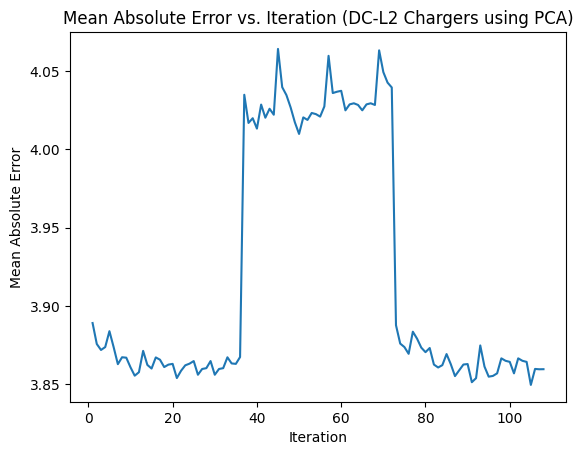

In [26]:

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_pca, Y_train_pca)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize an empty list to store MAE values after each iteration
mae_values_l2_PCA = []

# Perform cross-validation to get MAE after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train_pca, Y_train_pca)
        Y_pred = rf.predict(X_test_pca)
        mae = mean_absolute_error(Y_test_pca, Y_pred)
        mae_values_l2_PCA.append(mae)
        print(f"Iteration {i+1}: MAE = {mae}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")

# Plot MAE values
plt.plot(range(1, len(mae_values_l2_PCA) + 1), mae_values_l2_PCA, marker='', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration (L2 Chargers using PCA)')
plt.show()

c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\skle

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Iteration 1: 'max_features' is set to 'auto', skipping...
Iteration 2: 'max_features' is set to 'auto', skipping...
Iteration 3: 'max_features' is set to 'auto', skipping...
Iteration 4: 'max_features' is set to 'auto', skipping...
Iteration 5: 'max_features' is set to 'auto', skipping...
Iteration 6: 'max_features' is set to 'auto', skipping...
Iteration 7: 'max_features' is set to 'auto', skipping...
Iteration 8: 'max_features' is set to 'auto', skipping...
Iteration 9: 'max_features' is set to 'auto', skipping...
Iteration 10: 'max_features' is set to 'auto', skipping...
Iteration 11: 'max_features' is set to 'auto', skipping...
Iteration 12: 'max_features' is set to 'auto', skipping...
Iteration 13: 'max_features' is set to 'auto', skipping...
Iteration 14: 'max_features' is set to 'auto', skipping...
Iteration 15: 'max_features' is set to 'auto', skip

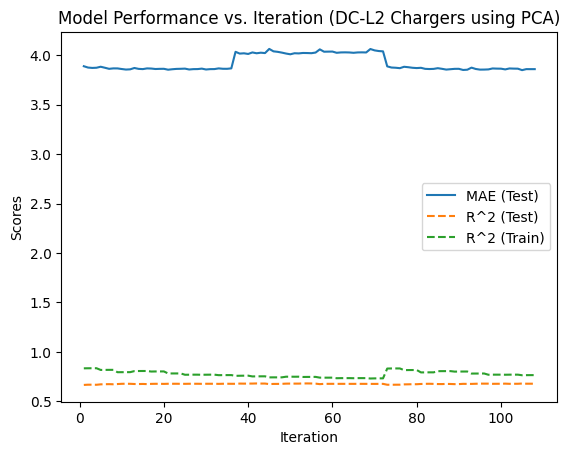

In [33]:


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_pca, Y_train_pca)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize empty lists to store MAE and validation scores after each iteration
mae_values_l2_PCA = []
val_scores_train = []
val_scores_test = []

# Perform cross-validation to get MAE and validation scores after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train_pca, Y_train_pca)
        
        # Predict on training and validation sets
        Y_train_pred = rf.predict(X_train_pca)
        Y_test_pred = rf.predict(X_test_pca)
        
        # Calculate MAE for testing set
        mae_test = mean_absolute_error(Y_test_pca, Y_test_pred)
        mae_values_l2_PCA.append(mae_test)
        
        # Calculate R^2 scores for training and testing sets
        val_score_train = rf.score(X_train_pca, Y_train_pca)
        val_score_test = rf.score(X_test_pca, Y_test_pca)
        
        val_scores_train.append(val_score_train)
        val_scores_test.append(val_score_test)
        
        print(f"Iteration {i+1}: MAE (Test) = {mae_test}, R^2 (Train) = {val_score_train}, R^2 (Test) = {val_score_test}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")

# Plot MAE values
plt.plot(range(1, len(mae_values_l2_PCA) + 1), mae_values_l2_PCA, marker='', linestyle='-', label='MAE (Test)')
plt.plot(range(1, len(val_scores_test) + 1), val_scores_test, marker='', linestyle='--', label='R^2 (Test)')
plt.plot(range(1, len(val_scores_train) + 1), val_scores_train, marker='', linestyle='--', label='R^2 (Train)')

plt.xlabel('Iteration')
plt.ylabel('Scores')
plt.title('Model Performance vs. Iteration (L2 Chargers using PCA)')
plt.legend()  # Show legend with labels
plt.show()


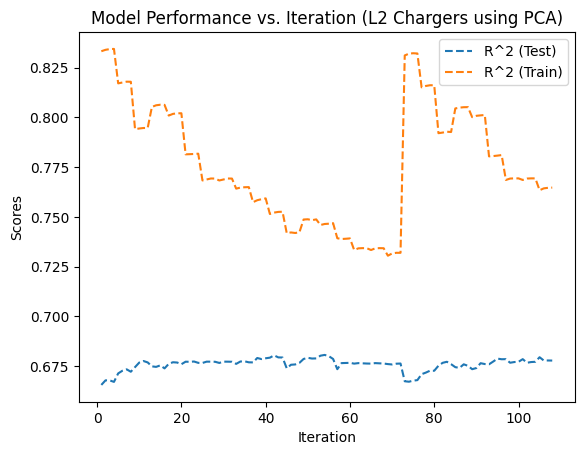

In [34]:
# Plot MAE values
#plt.plot(range(1, len(mae_values_l2_PCA) + 1), mae_values_l2_PCA, marker='', linestyle='-', label='MAE (Test)')
plt.plot(range(1, len(val_scores_test) + 1), val_scores_test, marker='', linestyle='--', label='R^2 (Test)')
plt.plot(range(1, len(val_scores_train) + 1), val_scores_train, marker='', linestyle='--', label='R^2 (Train)')

plt.xlabel('Iteration')
plt.ylabel('Scores')
plt.title('Model Performance vs. Iteration (L2 Chargers using PCA)')
plt.legend()  # Show legend with labels
plt.show()

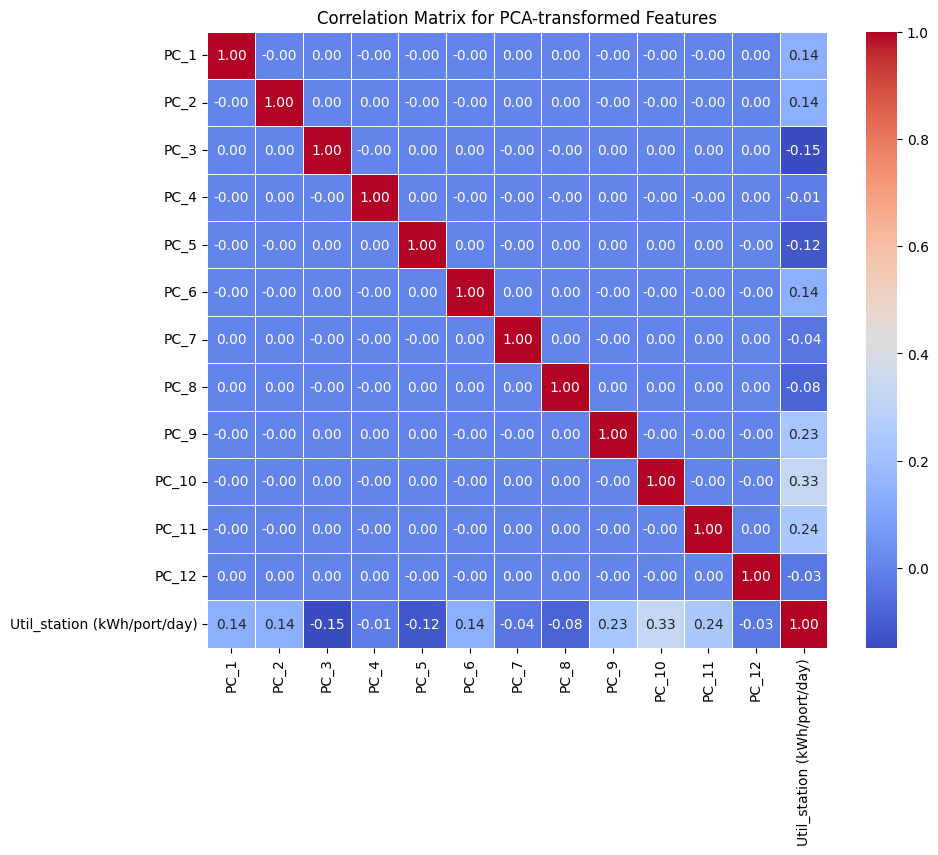

In [27]:
df_combined_pca = pd.concat([pd.DataFrame(X_pca, columns=[f"PC_{i+1}" for i in range(n_components)]), Y], axis=1)

correlations_pca = df_combined_pca.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlations_pca, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for PCA-transformed Features')
plt.show()


#   Plot together

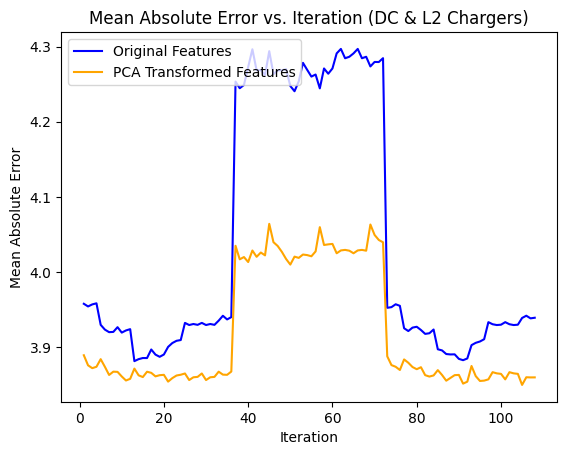

In [31]:

plt.plot(range(1, len(mae_values_L2_org) + 1), mae_values_L2_org, marker='', linestyle='-', color='blue', label='Original Features')

plt.plot(range(1, len(mae_values_l2_PCA) + 1), mae_values_l2_PCA, marker='', linestyle='-', color='orange', label='PCA Transformed Features')

plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration (DC & L2 Chargers)')
plt.legend(loc='upper left')  
plt.show()
